# Graph ConvNet

Neural network based on the paper: `Joshi, Laurent, and Bresson, ‘An Efficient Graph Convolutional Network Technique for the Travelling Salesman Problem’.`

Open questions:
* Difference between Linear and Embedding layer.
* Does it make a difference that no two Linear layers were used for the edge layer?
* Why are the biases disabled for eq 2 and eq 3 - in the paper they are present?
* How does Batch Normalisation work?
* How are class weights calculated
* log_softmax and NLLLoss vs CrossEntropy (CrossEntropy calculation meaning)

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

from model import GraphNet
from torch.utils.data import DataLoader
from utils.data import Data, VRPDataset
from utils.loader import load_config
from utils.model import save_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.spatial.distance import pdist, squareform

## Model Inputs

| Variable | Meaning | Dimensions |
| -------- | ------- | ---------- |
| batch_edges | Adj matrix special connections* | B x num_nodes x num_nodes
| batch_edges_values | Distance Matrix | B x num_nodes x num_nodes
| batch_edges_target | Target adj matrix | B x num_nodes x num_nodes
| batch_nodes | Ones vector | B x num_nodes
| batch_nodes_coord | Coordinates | B x num_nodes x 2
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [68]:
train, test = Data.load("vrp_11")

In [69]:
train_dataset, test_dataset = VRPDataset(train), VRPDataset(test)

In [70]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [283]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Visualise an instance

In [284]:
def first(tensor): return tensor[0]
def get_batch(dl): return next(iter(dl))

In [72]:
batch_features, batch_targets = next(iter(train_dataloader))
coords = first(batch_features[0]).cpu().numpy()
target = first(batch_targets).cpu().numpy()

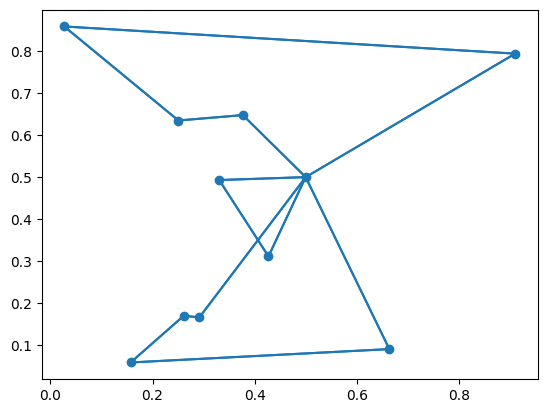

In [73]:
fig, ax = plt.subplots()

ax.scatter(coords[:, 0], coords[:, 1])

for i, row in enumerate(target):
    args = np.argwhere(row>0).flatten()
    x_i = coords[i]
    
    for x_j in coords[args]:
        ax.plot([x_i[0], x_j[0]], [x_i[1], x_j[1]], c='tab:blue')

plt.show()

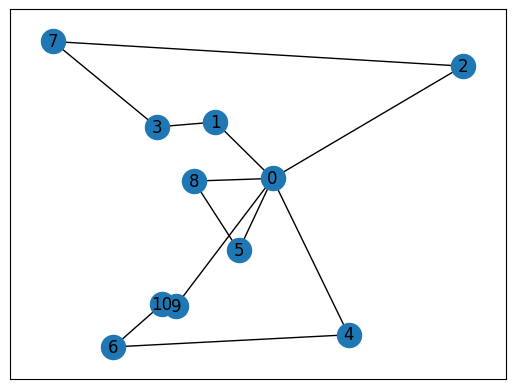

In [74]:
fig, ax = plt.subplots()

G = nx.from_numpy_array(target)
pos = dict(enumerate(coords))

nx.draw_networkx(G, pos, ax=ax)

plt.show()

## Compute class weights

Due to the class imbalance, we need to calculate the class weights.

In [75]:
targets = np.array([target_edges.cpu().numpy() for _, target_edges in train_dataset])

In [76]:
class_labels = targets.flatten()

edge_class_weights = compute_class_weight('balanced',
                                          classes=np.unique(class_labels),
                                          y=class_labels)
edge_class_weights = torch.tensor(edge_class_weights, dtype=torch.float)

## The Model

In [77]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device", device)

Device cpu


In [334]:
config = load_config(num_gcn_layers=1, hidden_dim=10)

In [335]:
LEARNING_RATE = 0.001

model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(edge_class_weights)

## Test Forward Pass

In [336]:
batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features

y_pred = model.forward(batch_coords, batch_edge_weights, batch_edge_values)

## Training Loop

In [337]:
def get_loss(y_pred, y_target):
    y = y_pred.permute(0, 3, 1, 2)
    
    return criterion(y, y_target)

def train_one_epoch(batch_coords, batch_demand, batch_edge_weights, batch_edge_values, batch_targets):
    model.train()
    
    optimizer.zero_grad()
    
    y_pred = model(batch_coords, batch_edge_weights, batch_edge_values)
    y_pred = y_pred.permute(0, 3, 1, 2)
    
    loss = criterion(y_pred, batch_targets)
    loss.backward()
    
    optimizer.step()

    return loss

def train(num_epochs, dataloader):
    epoch_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
    
        for batch_features, batch_targets in dataloader:
            batch_coords, batch_demand, batch_edge_weights, batch_edge_values = batch_features
            batch_coords = batch_coords.to(device)
            batch_demand = batch_demand.to(device)
            batch_edge_weights = batch_edge_weights.to(device)
            batch_edge_values = batch_edge_values.to(device)
            
            batch_targets = batch_targets.to(device)
            
            loss = train_one_epoch(batch_coords,
                                   batch_demand,
                                   batch_edge_weights,
                                   batch_edge_values,
                                   batch_targets)
            epoch_loss += loss.item()
            epoch_losses.append(epoch_loss)

        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

def eval_model(batch_coords, batch_demand, batch_edge_weights, batch_edge_values):
    model.eval()

    with torch.no_grad():
        y_pred = model(batch_coords, batch_edge_weights, batch_edge_values)

    return y_pred

In [338]:
train(20, train_dataloader)

Epoch: 00, Loss: 0.6569
Epoch: 01, Loss: 0.6020
Epoch: 02, Loss: 0.5554
Epoch: 03, Loss: 0.5173
Epoch: 04, Loss: 0.4714
Epoch: 05, Loss: 0.4527
Epoch: 06, Loss: 0.4298
Epoch: 07, Loss: 0.4317
Epoch: 08, Loss: 0.4500
Epoch: 09, Loss: 0.4222
Epoch: 10, Loss: 0.4311
Epoch: 11, Loss: 0.4261
Epoch: 12, Loss: 0.4443
Epoch: 13, Loss: 0.4340
Epoch: 14, Loss: 0.4293
Epoch: 15, Loss: 0.4168
Epoch: 16, Loss: 0.4288
Epoch: 17, Loss: 0.4310
Epoch: 18, Loss: 0.4212
Epoch: 19, Loss: 0.4184


In [339]:
save_model(model)

FileExistsError: File model.pt already exists

In [340]:
test_batch_features, test_targets = get_batch(test_dataloader)
test_coords, test_demand, test_edge_weights, test_edge_values = test_batch_features

In [341]:
preds = eval_model(test_coords, test_demand, test_edge_weights, test_edge_values)

In [342]:
preds = F.softmax(preds, dim=3)
preds = preds.argmax(dim=3)
preds = preds.cpu().numpy()

In [343]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

In [344]:
def plot_edge_predictions(coords, pred, target, ax):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3, ax=ax)

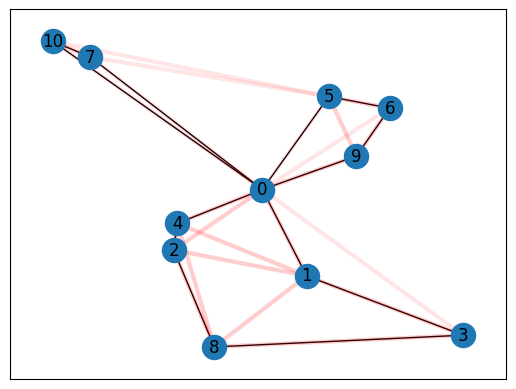

In [345]:
fig, ax = plt.subplots()
i = 15
plot_edge_predictions(test_coords[i].cpu().numpy(), preds[i], test_targets[i].cpu().numpy(), ax=ax)

In [264]:
def edge_errors(preds, targets):
    # how many true connections did it predict
    acc = (preds == targets).astype(int)
    # mask to ignore false predictions
    mask = np.copy(targets)
    acc = acc * targets

    acc = acc.sum(axis=2).sum(axis=1) / targets.sum(axis=2).sum(axis=1)
    acc = acc.mean()
    err_true_connection = 1 - acc
    
    # how many false connections did it predict
    acc = (preds == targets).astype(int)
    # mask to ignore false predictions (invert)
    mask = np.copy(targets)
    mask[targets==0] = 1
    mask[targets==1] = 0
    acc = acc * mask
    
    acc = acc.sum(axis=2).sum(axis=1) / mask.sum(axis=2).sum(axis=1)
    acc = acc.mean()
    err_false_connection = 1 - acc
    
    return err_true_connection, err_false_connection

In [266]:
targets = batch_targets.cpu().numpy()

true_edge_error, false_edge_error = edge_errors(preds, targets)
print(f"Correct: {true_edge_error:.2%}")
print(f"Wrong: {false_edge_error:.2%}")

Correct: 5.48%
Wrong: 15.85%


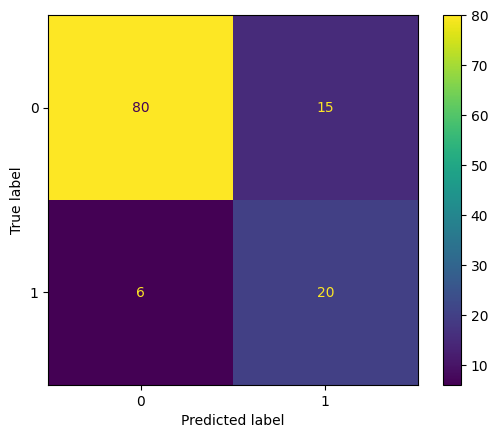

In [282]:
ConfusionMatrixDisplay.from_predictions(targets[0].flatten(), preds[0].flatten())
plt.show()